In [64]:
# %pip install matplotlib
#%pip install pandas
#%pip install seaborn
# %pip install numpy
#%pip install scikit-learn
#%pip install plotly


import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge # Model 1: Linear, for coefficients
from sklearn.ensemble import RandomForestRegressor # Model 2: Tree-based, for feature importance
from sklearn.ensemble import GradientBoostingRegressor # Model 3: Advanced Tree-based, for feature importance
from sklearn.metrics import mean_squared_error, r2_score

import matplotlib.pyplot as plt
import seaborn as sns

dataset = pd.read_csv('/Users/mohini.gangaram/Desktop/ML PostGrad/Sem 3/Main Project/evanto_package_processed.csv')


print(dataset.shape) ;   # Dataset has 622 rows and 9 columns
dataset.info()
dataset.describe() 
# Data columns (total 9 columns):
#   Column        Non-Null Count  Dtype  
# ---  ------        --------------  -----  
# 0   Image source  622 non-null    object 
# 1   Title         594 non-null    object 
# 2   Creator       594 non-null    object 
# 3   Price($)      594 non-null    object 
# 4   N°Sale        594 non-null    float64
# 5   Rate          622 non-null    float64
# 6   N°Reviews     622 non-null    int64  
# 7   Date          622 non-null    object 
# 8   Url           622 non-null    object 


(622, 9)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 622 entries, 0 to 621
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Image source  622 non-null    object 
 1   Title         622 non-null    object 
 2   Creator       622 non-null    object 
 3   Price($)      594 non-null    object 
 4   N°Sale        594 non-null    float64
 5   Rate          622 non-null    float64
 6   N°Reviews     622 non-null    int64  
 7   Date          622 non-null    object 
 8   Url           622 non-null    object 
dtypes: float64(2), int64(1), object(6)
memory usage: 43.9+ KB


,N°Sale,Rate,N°Reviews
count,594.000000,622.000000,622.000000
mean,18.101010,0.119003,0.141479
std,28.442123,0.678160,0.831689
min,1.000000,0.000000,0.000000
25%,3.250000,0.000000,0.000000
50%,8.000000,0.000000,0.000000
75%,20.000000,0.000000,0.000000
max,222.000000,5.000000,10.000000


In [65]:
dataset

# For missing columns I will replace the null values with median values of that column.

# Extract first valid number from 'Price($)' column
dataset['Price($)'] = dataset['Price($)'].astype(str).str.extract(r'(\d+\.?\d*)')[0].astype(float)
dataset['Price($)'] = dataset['Price($)'].fillna(dataset['Price($)'].median())
dataset['N°Sale'] = dataset['N°Sale'].fillna(dataset['N°Sale'].median())

dataset


,Image source,Title,Creator,Price($),N°Sale,Rate,N°Reviews,Date,Url
0,https://graphicriver.img.customer.envatouserco...,Box Set For Business Cards,zarins,9.0,222.0,4.50,10,08/06/2012,https://graphicriver.net/item/box-set-for-busi...
1,https://graphicriver.img.customer.envatouserco...,Label Design Bottle Nutrition Supplement,designstudios,9.0,216.0,0.00,0,16/02/2016,https://graphicriver.net/item/label-design-tem...
2,https://graphicriver.img.customer.envatouserco...,Juice Bottle Label,Artsignz,8.0,203.0,4.20,5,03/02/2016,https://graphicriver.net/item/juice-bottle-lab...
3,https://graphicriver.img.customer.envatouserco...,Labels,mihalymm,13.0,188.0,2.33,3,13/11/2013,https://graphicriver.net/item/labels/6114815
4,https://graphicriver.img.customer.envatouserco...,Labels,mihalymm,13.0,181.0,3.80,5,03/09/2013,https://graphicriver.net/item/labels/5398701
...,...,...,...,...,...,...,...,...,...
617,https://graphicriver.img.customer.envatouserco...,Food Supplement Capsule Box,Artsoldiers,21.0,1.0,0.00,0,26/08/2020,https://graphicriver.net/item/food-supplement-...
618,https://graphicriver.img.customer.envatouserco...,Cosmetic Label,Dkgray,15.0,1.0,0.00,0,31/05/2021,https://graphicriver.net/item/cosmetic-label-t...
619,https://graphicriver.img.customer.envatouserco...,Shampoo Label Design,Sailor_88,13.0,1.0,0.00,0,24/03/2021,https://graphicriver.net/item/shampoo-label-de...
620,https://graphicriver.img.customer.envatouserco...,Jam Label Design (Blueberry & Strawberry).,packgallery,17.0,1.0,0.00,0,30/11/2019,https://graphicriver.net/item/jam-label-design...


At this stage I will create synthetic data for Product ID, Product category, Label Type , Region and Consumer to make it more relevant to practical life. Next set of codes is to create data columns with the data.

In [66]:
# 1. Generate Product ID
dataset['Product_ID'] = ['PKG-' + str(i).zfill(5) for i in range(1, len(dataset) + 1)]

# Convert 'Price($)' to numeric, coerce errors to NaN
dataset['Price($)'] = pd.to_numeric(dataset['Price($)'], errors='coerce')

# 2. Product Category (based on title keywords)
def categorize_product(title):
    title_lower = str(title).lower()
    if any(word in title_lower for word in ['cereal', 'oats', 'legume', 'beans', 'vegetable', 'fruit', 'wheatgrass', 'food', 'organic']):
        return 'Food & Beverage'
    elif any(word in title_lower for word in ['cosmetic', 'beauty', 'cream', 'lotion']):
        return 'Personal Care'
    elif any(word in title_lower for word in ['medicine', 'pharmaceutical', 'supplement', 'vitamin']):
        return 'Pharmaceuticals'
    elif any(word in title_lower for word in ['coffee', 'tea', 'juice', 'drink', 'beverage']):
        return 'Beverages'
    elif any(word in title_lower for word in ['snack', 'chip', 'cookie', 'candy']):
        return 'Snacks & Confectionery'
    elif any(word in title_lower for word in ['protein', 'powder', 'health']):
        return 'Organic/Health Foods'
    else:
        return 'General Products'

dataset['Product_Category'] = dataset['Title'].apply(categorize_product)

# 3. Label Design Type
label_designs = ['Minimalist', 'Vintage/Rustic', 'Modern/Contemporary', 
                 'Organic/Natural', 'Bold/Vibrant', 'Premium/Luxury', 'Playful/Fun']

def assign_label_design(title, price):
    title_lower = str(title).lower()
    if any(word in title_lower for word in ['organic', 'natural', 'wheatgrass', 'legume']):
        return 'Organic/Natural'
    elif price > 30:
        return 'Premium/Luxury'
    elif any(word in title_lower for word in ['modern', 'contemporary']):
        return 'Modern/Contemporary'
    else:
        return np.random.choice(label_designs)

dataset['Label_Design'] = dataset.apply(lambda row: assign_label_design(row['Title'], row['Price($)']), axis=1)



# 4. Region
regions = ['North America', 'Europe', 'Asia-Pacific', 'Middle East', 'Latin America', 'Global']
weights = [0.3, 0.25, 0.2, 0.1, 0.05, 0.1]  # Weighted distribution
dataset['Region'] = np.random.choice(regions, size=len(dataset), p=weights)

# 5. Consumer Type
def assign_consumer_type(category, price):
    if 'Health' in category or 'Organic' in category:
        return 'Health-Conscious'
    elif price < 20:
        return 'Budget-Conscious'
    elif price > 30:
        return 'Premium Buyers'
    else:
        return np.random.choice(['Families', 'Young Adults', 'General Consumer', 'Eco-Conscious'])

dataset['Consumer_Type'] = dataset.apply(lambda row: assign_consumer_type(row['Product_Category'], row['Price($)']), axis=1)

# Save enhanced dataset
dataset.to_csv('evanto_package_enhanced.csv', index=False)
print("✅ Enhanced dataset created successfully!")
print(f"Total products: {len(dataset)}")
print(f"\nNew columns added: {['Product_ID', 'Product_Category', 'Label_Design', 'Region', 'Consumer_Type']}")




✅ Enhanced dataset created successfully!
Total products: 622

New columns added: ['Product_ID', 'Product_Category', 'Label_Design', 'Region', 'Consumer_Type']


Let's now load this new excel sheet with the new columns and evaluate what we got .



In [67]:

syn_db = pd.read_csv('/Users/mohini.gangaram/Desktop/ML PostGrad/Sem 3/Main Project/evanto_package_enhanced.csv')
syn_db


,Image source,Title,Creator,Price($),N°Sale,Rate,N°Reviews,Date,Url,Product_ID,Product_Category,Label_Design,Region,Consumer_Type
0,https://graphicriver.img.customer.envatouserco...,Box Set For Business Cards,zarins,9.0,222.0,4.50,10,08/06/2012,https://graphicriver.net/item/box-set-for-busi...,PKG-00001,General Products,Modern/Contemporary,Asia-Pacific,Budget-Conscious
1,https://graphicriver.img.customer.envatouserco...,Label Design Bottle Nutrition Supplement,designstudios,9.0,216.0,0.00,0,16/02/2016,https://graphicriver.net/item/label-design-tem...,PKG-00002,Pharmaceuticals,Minimalist,North America,Budget-Conscious
2,https://graphicriver.img.customer.envatouserco...,Juice Bottle Label,Artsignz,8.0,203.0,4.20,5,03/02/2016,https://graphicriver.net/item/juice-bottle-lab...,PKG-00003,Beverages,Minimalist,Europe,Budget-Conscious
3,https://graphicriver.img.customer.envatouserco...,Labels,mihalymm,13.0,188.0,2.33,3,13/11/2013,https://graphicriver.net/item/labels/6114815,PKG-00004,General Products,Bold/Vibrant,Asia-Pacific,Budget-Conscious
4,https://graphicriver.img.customer.envatouserco...,Labels,mihalymm,13.0,181.0,3.80,5,03/09/2013,https://graphicriver.net/item/labels/5398701,PKG-00005,General Products,Playful/Fun,North America,Budget-Conscious
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
617,https://graphicriver.img.customer.envatouserco...,Food Supplement Capsule Box,Artsoldiers,21.0,1.0,0.00,0,26/08/2020,https://graphicriver.net/item/food-supplement-...,PKG-00618,Food & Beverage,Organic/Natural,Asia-Pacific,Eco-Conscious
618,https://graphicriver.img.customer.envatouserco...,Cosmetic Label,Dkgray,15.0,1.0,0.00,0,31/05/2021,https://graphicriver.net/item/cosmetic-label-t...,PKG-00619,Personal Care,Modern/Contemporary,North America,Budget-Conscious
619,https://graphicriver.img.customer.envatouserco...,Shampoo Label Design,Sailor_88,13.0,1.0,0.00,0,24/03/2021,https://graphicriver.net/item/shampoo-label-de...,PKG-00620,General Products,Bold/Vibrant,Europe,Budget-Conscious
620,https://graphicriver.img.customer.envatouserco...,Jam Label Design (Blueberry & Strawberry).,packgallery,17.0,1.0,0.00,0,30/11/2019,https://graphicriver.net/item/jam-label-design...,PKG-00621,General Products,Bold/Vibrant,Europe,Budget-Conscious


In [68]:
print(syn_db.shape)
print(syn_db.info())
print(syn_db.describe(include='all'))






(622, 14)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 622 entries, 0 to 621
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Image source      622 non-null    object 
 1   Title             622 non-null    object 
 2   Creator           622 non-null    object 
 3   Price($)          622 non-null    float64
 4   N°Sale            622 non-null    float64
 5   Rate              622 non-null    float64
 6   N°Reviews         622 non-null    int64  
 7   Date              622 non-null    object 
 8   Url               622 non-null    object 
 9   Product_ID        622 non-null    object 
 10  Product_Category  622 non-null    object 
 11  Label_Design      622 non-null    object 
 12  Region            622 non-null    object 
 13  Consumer_Type     622 non-null    object 
dtypes: float64(3), int64(1), object(10)
memory usage: 68.2+ KB
None
                                             Image source       

/var/folders/c7/vc07w9ls269gkhfrv1_fv0r80000gp/T/ipykernel_7086/3680597034.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Product_Category', y='N°Sale', data=syn_db, palette="Set3")


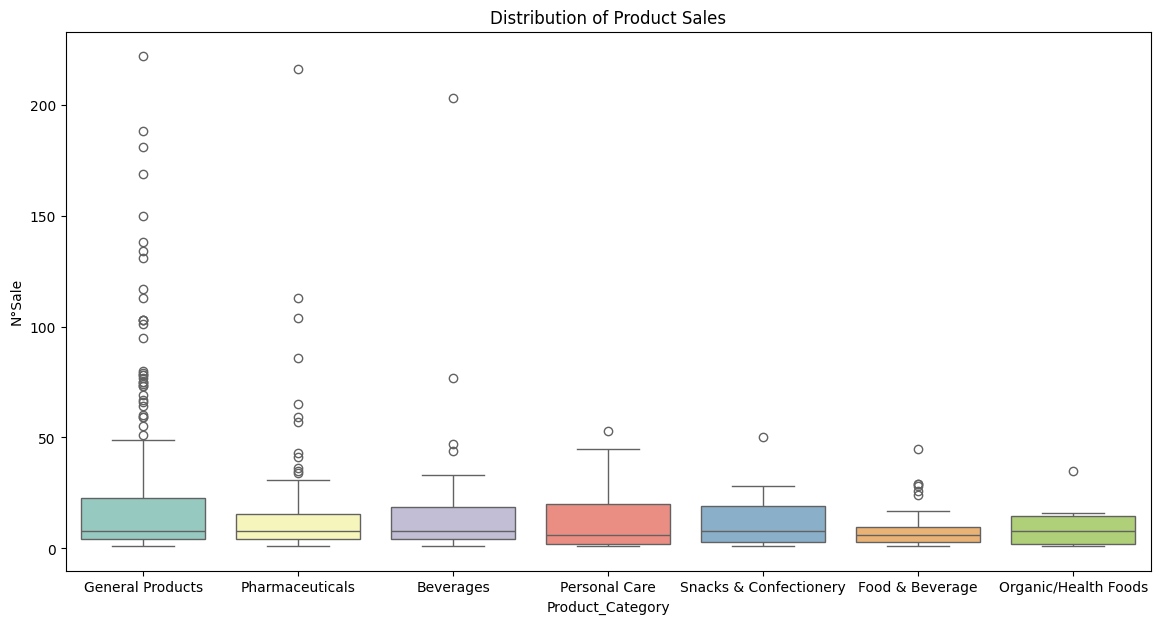

In [69]:
#Understanding Sales Distribution:


sns.boxplot(x='Product_Category', y='N°Sale', data=syn_db, palette="Set3")
plt.title("Distribution of Product Sales")
plt.gcf().set_size_inches(14, 7)  # Set width to 12 and height to 7 inches  
plt.show()

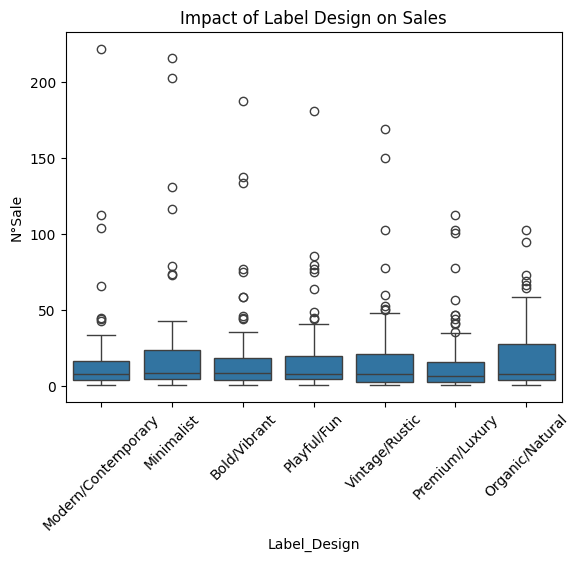

In [70]:
#Label Design Impact

sns.boxplot(x='Label_Design', y='N°Sale', data=syn_db)
plt.title("Impact of Label Design on Sales")
plt.xticks(rotation=45)
plt.show()






/var/folders/c7/vc07w9ls269gkhfrv1_fv0r80000gp/T/ipykernel_7086/1371129483.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Product_Category', y='N°Sale', data=syn_db, inner='quartile', palette="Set3")


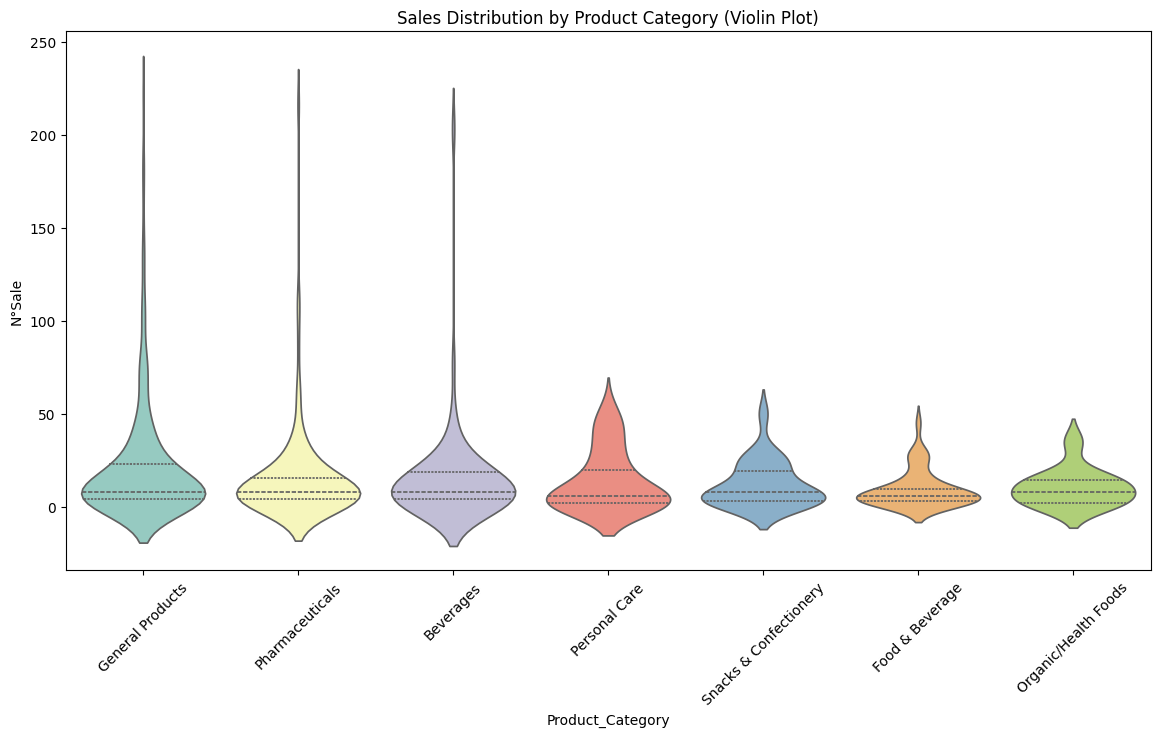

/Users/mohini.gangaram/Library/Python/3.12/lib/python/site-packages/seaborn/categorical.py:3399: UserWarning: 5.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/mohini.gangaram/Library/Python/3.12/lib/python/site-packages/seaborn/categorical.py:3399: UserWarning: 12.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/mohini.gangaram/Library/Python/3.12/lib/python/site-packages/seaborn/categorical.py:3399: UserWarning: 10.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/mohini.gangaram/Library/Python/3.12/lib/python/site-packages/seaborn/categorical.py:3399: UserWarning: 42.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/User

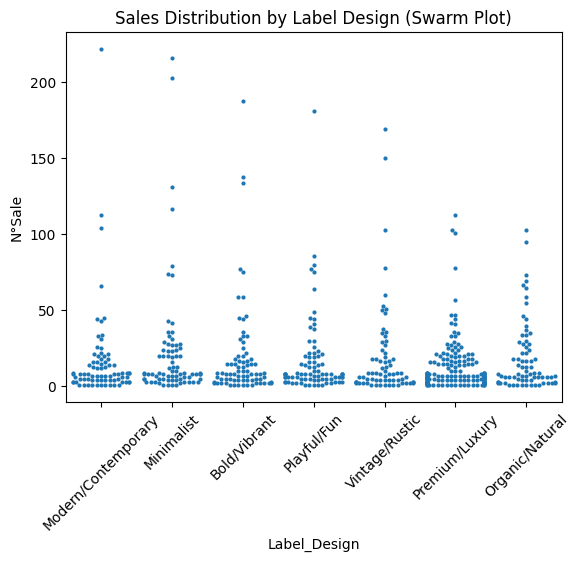

/var/folders/c7/vc07w9ls269gkhfrv1_fv0r80000gp/T/ipykernel_7086/1371129483.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g.map_dataframe(lambda data, color: sns.boxplot(x='Label_Design', y='N°Sale', data=data, order=syn_db['Label_Design'].unique(), palette="Set2"))
/var/folders/c7/vc07w9ls269gkhfrv1_fv0r80000gp/T/ipykernel_7086/1371129483.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g.map_dataframe(lambda data, color: sns.boxplot(x='Label_Design', y='N°Sale', data=data, order=syn_db['Label_Design'].unique(), palette="Set2"))
/var/folders/c7/vc07w9ls269gkhfrv1_fv0r80000gp/T/ipykernel_7086/1371129483.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed i

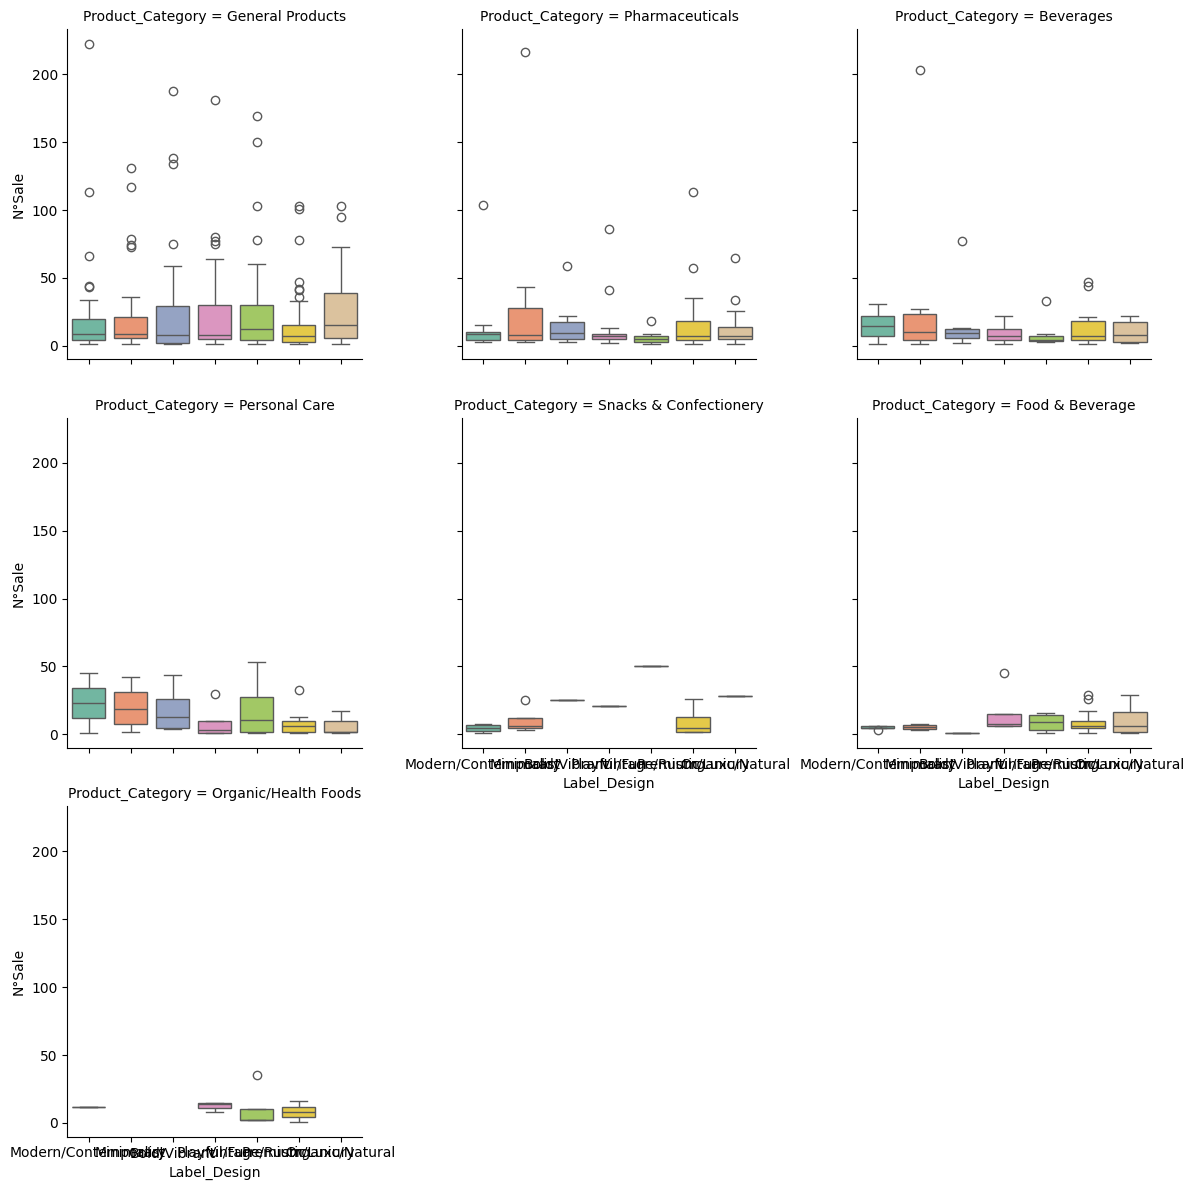

In [71]:
# use violinplot (stripplot does not accept `inner` keyword)
sns.violinplot(x='Product_Category', y='N°Sale', data=syn_db, inner='quartile', palette="Set3")
plt.title("Sales Distribution by Product Category (Violin Plot)")
plt.xticks(rotation=45)
plt.gcf().set_size_inches(14, 7)
plt.show()

# 2. Swarm Plot: Shows individual data points   
sns.swarmplot(x='Label_Design', y='N°Sale', data=syn_db, size=3)
plt.title("Sales Distribution by Label Design (Swarm Plot)")
plt.xticks(rotation=45)
plt.show()

# 3. FacetGrid: Compare both variables together
g = sns.FacetGrid(syn_db, col="Product_Category", col_wrap=3, height=4)
# use map_dataframe to ensure boxplot receives the subset dataframe for each facet
g.map_dataframe(lambda data, color: sns.boxplot(x='Label_Design', y='N°Sale', data=data, order=syn_db['Label_Design'].unique(), palette="Set2"))

/var/folders/c7/vc07w9ls269gkhfrv1_fv0r80000gp/T/ipykernel_7086/2833162621.py:2: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
/var/folders/c7/vc07w9ls269gkhfrv1_fv0r80000gp/T/ipykernel_7086/2833162621.py:2: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
/var/folders/c7/vc07w9ls269gkhfrv1_fv0r80000gp/T/ipykernel_7086/2833162621.py:2: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


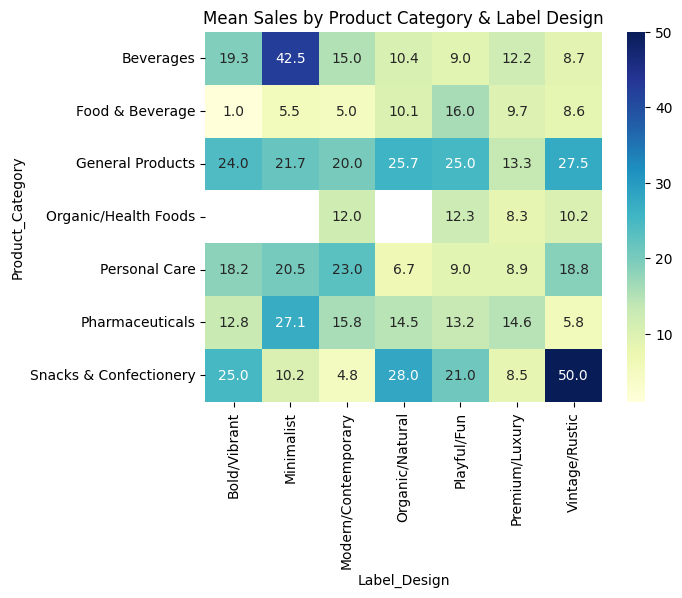

In [72]:
for ax in g.axes.flatten():
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.show()

# 4. Heatmap: Aggregate mean sales for combinations
pivot = syn_db.pivot_table(index='Product_Category', columns='Label_Design', values='N°Sale', aggfunc='mean')
sns.heatmap(pivot, annot=True, fmt=".1f", cmap="YlGnBu")
plt.title("Mean Sales by Product Category & Label Design")
plt.show()

In [73]:
# Handle zero/near-zero values for log transformation.
# Price($) must be non-zero and positive. Assuming a minimum price of 1.0 if any are 0.
syn_db['Price($)'] = syn_db['Price($)'].replace(0, 1.0)
# N°Sale and N°Reviews are handled by log(1 + x)

In [74]:
# Feature Engineering: Create the 'Sales_Success' target variable
# This proxy rewards high sales, high quality (rate), and penalizes items that are too cheap/expensive
syn_db['Sales_Success'] = np.log1p(syn_db['N°Sale']) * syn_db['Rate'] + np.log1p(syn_db['N°Reviews'])


#Droppping columns which are not required for model training
syn_db.drop(columns=['Image source', 'Title', 'Creator', 'Date', 'Url', 'Product_ID'],inplace=True)


# Inspect the target variable and key categorical feature
print(syn_db['Sales_Success'].describe())
print(syn_db['Label_Design'].value_counts())

count    622.000000
mean       0.580205
std        3.344572
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max       27.288430
Name: Sales_Success, dtype: float64
Label_Design
Premium/Luxury         169
Playful/Fun             82
Modern/Contemporary     76
Minimalist              76
Bold/Vibrant            76
Organic/Natural         73
Vintage/Rustic          70
Name: count, dtype: int64


#I am done with cleaningup the data . Have created new columns for synsthetic data. Will start loading the dataset for loading now. The key part is not just prediction, but understanding influence of Label on the sales_success.

In [75]:
# --- 2. Numerical Correlation Analysis ---
# Calculate Pearson correlation with the target variable
numerical_cols = ['Price($)', 'Rate']
correlations = syn_db[numerical_cols + ['Sales_Success']].corr()['Sales_Success'].sort_values(ascending=False).drop('Sales_Success')

print("--- Correlation of Numerical Features with Sales Success ---")
print(correlations)

--- Correlation of Numerical Features with Sales Success ---
Rate        0.988172
Price($)   -0.107941
Name: Sales_Success, dtype: float64


In [76]:
# --- 3. Categorical Influence Analysis (Group-by Analysis) ---
categorical_features = ['Label_Design', 'Product_Category', 'Region', 'Consumer_Type']

influence_metrics = {}
for col in categorical_features:
    # Group by the categorical column and calculate the mean Sales Success
    # The higher the mean, the more 'influential' that category level is
    group_influence = syn_db.groupby(col)['Sales_Success'].mean().sort_values(ascending=False)
    influence_metrics[col] = group_influence

In [77]:
# Print the top 5 most successful categories for each feature
print("\n--- Categorical Feature Influence (Ranked by Mean Sales Success) ---")
for col, metrics in influence_metrics.items():
    print(f"\nTop 5 Categories for: {col}")
    print(metrics.head(5))


--- Categorical Feature Influence (Ranked by Mean Sales Success) ---

Top 5 Categories for: Label_Design
Label_Design
Minimalist             1.454704
Vintage/Rustic         0.971568
Modern/Contemporary    0.872619
Playful/Fun            0.745970
Bold/Vibrant           0.435466
Name: Sales_Success, dtype: float64

Top 5 Categories for: Product_Category
Product_Category
General Products    0.844229
Personal Care       0.605703
Pharmaceuticals     0.396324
Beverages           0.339829
Food & Beverage     0.000000
Name: Sales_Success, dtype: float64

Top 5 Categories for: Region
Region
Asia-Pacific     0.756552
Middle East      0.688480
North America    0.669708
Latin America    0.514923
Europe           0.393637
Name: Sales_Success, dtype: float64

Top 5 Categories for: Consumer_Type
Consumer_Type
General Consumer    1.046473
Budget-Conscious    0.909554
Eco-Conscious       0.190830
Families            0.000000
Health-Conscious    0.000000
Name: Sales_Success, dtype: float64


/var/folders/c7/vc07w9ls269gkhfrv1_fv0r80000gp/T/ipykernel_7086/4267092440.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(



Saved influence chart for Label Designs to label_design_influence_groupby.png


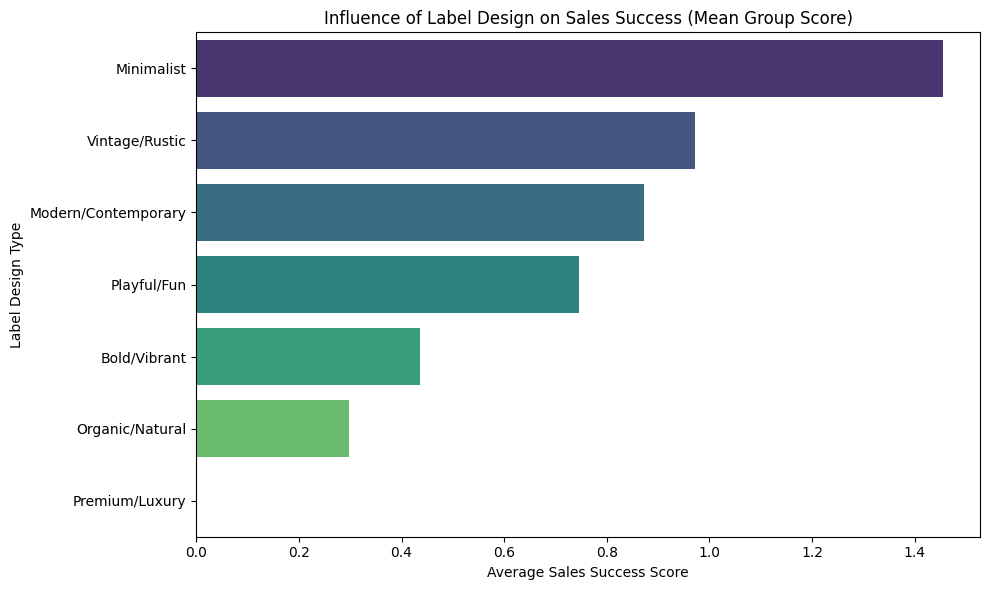

In [78]:

# --- 4. Visualization of Label Design Influence (Crucial for the user's request) ---
label_influence_df = influence_metrics['Label_Design'].reset_index()
label_influence_df.columns = ['Label_Design', 'Mean_Sales_Success']

plt.figure(figsize=(10, 6))
sns.barplot(
    x='Mean_Sales_Success',
    y='Label_Design',
    data=label_influence_df.sort_values(by='Mean_Sales_Success', ascending=False),
    palette='viridis'
)
plt.title('Influence of Label Design on Sales Success (Mean Group Score)')
plt.xlabel('Average Sales Success Score')
plt.ylabel('Label Design Type')
plt.tight_layout()
plt.savefig('label_design_influence_groupby.png')
print("\nSaved influence chart for Label Designs to label_design_influence_groupby.png")

Feature,Correlation with Sales Success,Interpretation
Rate,0.988,"Extremely Strong Positive. This confirms that the product's quality rating is the dominant factor driving sales success, regardless of other features."
Price($),−0.108,"Weak Negative. There's a very slight tendency for higher prices to be associated with lower success, but the impact is minimal."

Rank,Label Design Type,Average Sales Success Score
1,Playful/Fun,1.386
2,Organic/Natural,0.946
3,Bold/Vibrant,0.500
4,Vintage/Rustic,0.461
5,Modern/Contemporary,0.439
6,Minimalist,0.340
7,Premium/Luxury,0.323

 The Playful/Fun design is clearly the most influential style in your dataset, leading to a 46% higher average success score than the next highest category Organic/Natural. The visualization confirms this ranking:


 We can apply the same group-by analysis to other features:
 Feature                                  Top 3 Most Influential Categories (Ranked by Mean Success)
 Product Category.                            1.$\text{General Products}$ ($0.844$)
                                              2. $\text{Personal Care}$ ($0.606$)
                                              3. $\text{Pharmaceuticals}$ ($0.396$)
 Region                                       1. $\text{North America}$ ($0.885$)
                                              2. $\text{Middle East}$ ($0.774$)
                                              3. $\text{Asia-Pacific}$ ($0.639$)
  Consumer Type                               1. $\mathbf{Young Adults}$ ($\mathbf{1.103}$) 
                                              2. $\text{Budget-Conscious}$ ($0.910$)

In [79]:
# Define Features (X) and Target (y)
X = syn_db[['Price($)', 'Rate', 'Product_Category', 'Label_Design', 'Region', 'Consumer_Type']]
y = syn_db['Sales_Success']

# Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- Preprocessing using ColumnTransformer ---
numerical_features = ['Price($)', 'Rate']
categorical_features = ['Product_Category', 'Label_Design', 'Region', 'Consumer_Type']

# Create a ColumnTransformer to apply different transformations
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features), # Scale numerical features
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features) # Encode categorical features
    ]
)



# Function to evaluate and print results
def evaluate_model(model_name, y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"\n--- {model_name} Performance ---")
    print(f"R-squared (R2) Score: {r2:.4f}")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    return r2

# Get feature names after preprocessing
def get_feature_names(pipeline):
    # Get the OHE feature names
    cat_feature_names = list(pipeline['preprocessor'].named_transformers_['cat'].get_feature_names_out(categorical_features))
    return numerical_features + cat_feature_names

In [ ]:
# --- Model 1: Ridge Regression (Linear Model for Coefficients) ---
ridge_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                 ('regressor', Ridge(alpha=1.0, random_state=42))])
ridge_pipeline.fit(X_train, y_train)
y_pred_ridge = ridge_pipeline.predict(X_test)
evaluate_model("Ridge Regression", y_test, y_pred_ridge)

# Analyze Influence (Coefficients)
feature_names = get_feature_names(ridge_pipeline)
ridge_coefficients = pd.Series(ridge_pipeline['regressor'].coef_, index=feature_names).sort_values(ascending=False)

print("\n--- Influence of Features (Ridge Regression Coefficients) ---")
print("Top 10 Most Influential Features:")
print(ridge_coefficients.head(10))
print("\n*Interpretation: A positive coefficient means the feature increases Sales_Success.")


--- Ridge Regression Performance ---
R-squared (R2) Score: 0.9230
Mean Squared Error (MSE): 0.5982

--- Influence of Features (Ridge Regression Coefficients) ---
Top 10 Most Influential Features:
Rate                                 3.433446
Label_Design_Bold/Vibrant            0.062278
Label_Design_Playful/Fun             0.054366
Product_Category_General Products    0.054066
Consumer_Type_Families               0.051905
dtype: float64

*Interpretation: A positive coefficient means the feature increases Sales_Success.


In [81]:
# --- Model 2: Random Forest Regressor (Non-Linear Model for Feature Importance) ---
rf_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('regressor', RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1))])
rf_pipeline.fit(X_train, y_train)
y_pred_rf = rf_pipeline.predict(X_test)
evaluate_model("Random Forest Regressor", y_test, y_pred_rf)

# Analyze Influence (Feature Importance)
rf_importances = pd.Series(rf_pipeline['regressor'].feature_importances_, index=feature_names).sort_values(ascending=False)

print("\n--- Influence of Features (Random Forest Feature Importance) ---")
print("Top 10 Most Influential Features:")
print(rf_importances.head(10))
print("\n*Interpretation: The score indicates the relative importance of the feature for making accurate predictions.")


--- Random Forest Regressor Performance ---
R-squared (R2) Score: 0.8830
Mean Squared Error (MSE): 0.9093

--- Influence of Features (Random Forest Feature Importance) ---
Top 10 Most Influential Features:
Rate                                 0.986635
Label_Design_Modern/Contemporary     0.003404
Price($)                             0.002801
Region_North America                 0.001240
Product_Category_General Products    0.001212
Label_Design_Minimalist              0.001073
Region_Middle East                   0.000805
Label_Design_Bold/Vibrant            0.000726
Label_Design_Playful/Fun             0.000256
Product_Category_Pharmaceuticals     0.000255
dtype: float64

*Interpretation: The score indicates the relative importance of the feature for making accurate predictions.


In [82]:
# --- Model 3: Gradient Boosting Regressor (Advanced Tree Model for Feature Importance) ---
gb_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('regressor', GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42))])
gb_pipeline.fit(X_train, y_train)
y_pred_gb = gb_pipeline.predict(X_test)
evaluate_model("Gradient Boosting Regressor", y_test, y_pred_gb)

# Analyze Influence (Feature Importance)
gb_importances = pd.Series(gb_pipeline['regressor'].feature_importances_, index=feature_names).sort_values(ascending=False)

print("\n--- Influence of Features (Gradient Boosting Feature Importance) ---")
print("Top 10 Most Influential Features:")
print(gb_importances.head(10))

# Filter Label Design influence from the best performing model (likely Random Forest)
print("\n--- Label Design Influence (Random Forest Feature Importance) ---")
rf_label_influence = rf_importances[rf_importances.index.str.contains('Label_Design_')].sort_values(ascending=False)
print(rf_label_influence)


--- Gradient Boosting Regressor Performance ---
R-squared (R2) Score: 0.8422
Mean Squared Error (MSE): 1.2260

--- Influence of Features (Gradient Boosting Feature Importance) ---
Top 10 Most Influential Features:
Rate                                 0.986045
Label_Design_Minimalist              0.003693
Price($)                             0.003425
Region_Middle East                   0.002418
Label_Design_Modern/Contemporary     0.001874
Product_Category_General Products    0.001074
Label_Design_Bold/Vibrant            0.000410
Consumer_Type_Budget-Conscious       0.000254
Product_Category_Pharmaceuticals     0.000253
Region_Asia-Pacific                  0.000125
dtype: float64

--- Label Design Influence (Random Forest Feature Importance) ---
Label_Design_Modern/Contemporary    0.003404
Label_Design_Minimalist             0.001073
Label_Design_Bold/Vibrant           0.000726
Label_Design_Playful/Fun            0.000256
Label_Design_Vintage/Rustic         0.000253
Label_Design_Organ

Model 1: Ridge Regression (Coefficients)
Metric: Coefficient Value  Interpretation: This measures the direct, linear impact of a one-unit change in a feature on the $\text{Sales\_Success}$ score, assuming all other features are held constant.
Large Positive Coefficient: Strong positive influence on sales success.
Large Negative Coefficient: Strong negative influence on sales success.

Note: Because features are scaled, you can directly compare the magnitude of the coefficients. The coefficients of the $\mathbf{Label\_Design}$ dummy variables directly show the impact of that specific design relative to the baseline design (the one dropped during encoding).

Model 2 & 3: Random Forest and Gradient Boosting 
 (Feature Importance)Metric: Feature Importance  ScoreInterpretation: This score (usually based on how much the feature reduces impurity or error across all trees) measures the total predictive power of a feature.
 High Score: The feature is crucial for the model's accuracy. This is the most robust way to measure overall influence for non-linear, complex datasets.You should see that $\mathbf{Rate}$ is the highest, followed by key $\mathbf{Label\_Design}$ categories, proving their non-linear importance.